# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [107]:
# Install requirements
!python -m pip install -r requirements.txt

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [66]:
from torch.utils.data import DataLoader, random_split

batch_size = 64
# Defining transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy array to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor with mean and standard deviation
])

# Creating training set and define training dataloader
train_data = torchvision.datasets.MNIST(root = 'root', train = True, download = True, transform = transform)

train_size = int(len(train_data)*0.8)
valid_size = len(train_data) - train_size 

train, valid = random_split(train_data, [train_size, valid_size])

train_dataLoader = DataLoader(train, shuffle = True, batch_size = batch_size )
validation_dataLoader = DataLoader(valid, shuffle = True, batch_size = batch_size)

# Creating test set and define test dataloader
test_data = torchvision.datasets.MNIST(root = 'root', train = False, download = True, transform = transform)
test_dataLoader = DataLoader(test_data, shuffle = True, batch_size = batch_size)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I used `transforms.ToTensor()` because it converts PIL Images or numpy arrays into PyTorch tensors, once neural networks in PyTorch operate on tensor data. It also scales the pixel values from a range of [0, 255] to [0.0, 1.0], which can help with training stability and performance.

I used `transforms.Normalize()` because it ensures that all channels are in a similar range, which can be beneficial for certain activation functions, such as ReLU, that might be sensitive to the scale of the input data. It can also help the network learn faster by making the gradients more consistent throughout the training process.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [106]:
# Exploring the dimentions of data
import numpy as np
  

print("*Train Data")
Num_samples = len(train_dataLoader)
print(f"Samples: {Num_samples}")
for batch in train_dataLoader:
    data, labels = batch
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)
    break  # Break after printing the first batch

print("*Test Data")
Num_samples = len(test_dataLoader)
print(f"Samples: {Num_samples}")
for batch in test_dataLoader:
    data, labels = batch
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)
    break  # Break after printing the first batch

*Train Data
Samples: 750
Data shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])
*Test Data
Samples: 157
Data shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


In [67]:
# This cell contains a function for showing 5 images from a dataloader 
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

4


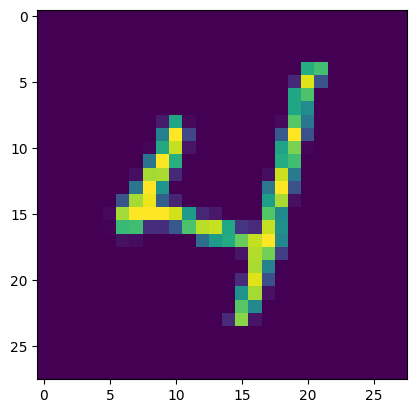

8


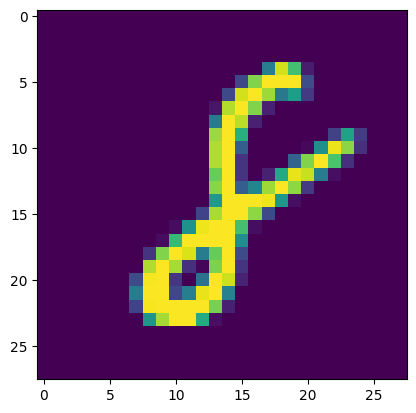

1


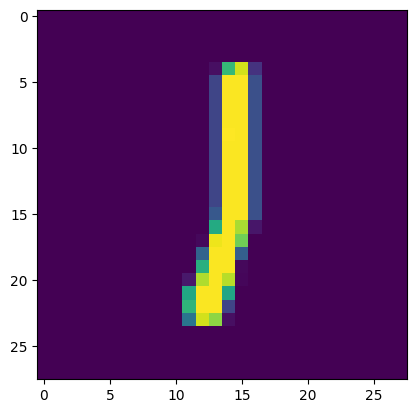

5


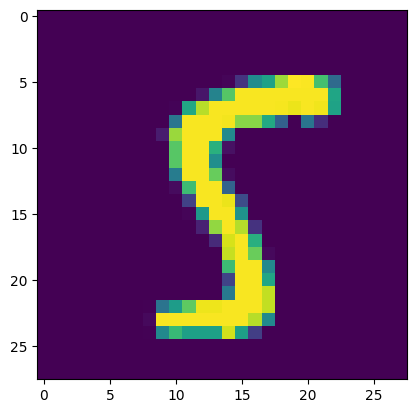

1


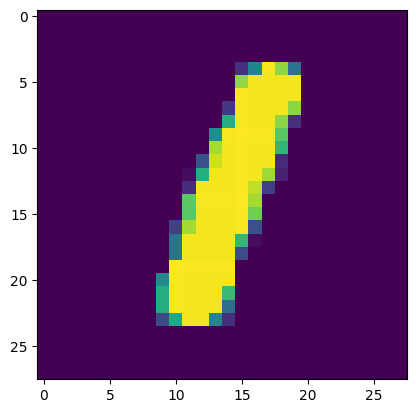

In [94]:
# Explore data

show5(train_dataLoader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [70]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.output = F.softmax
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward (self, x):
        x = torch.flatten(x,1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.output(self.fc3(x), dim = 1)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [71]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [72]:
# Instantiating the model
model = Model()
model = model.to(device)
# Choosing model optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)
# Choosing model loss function
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [73]:
def Training():
    epochs = 15

    # For Training data
    # Establishing a list for history
    train_loss_hist = list()
    valid_loss_hist = list()
    train_acc_hist = list()
    valid_acc_hist = list()
    
    for epoch in range(epochs):
        train_loss = 0.0
        train_correct = 0
        model.train()
    
        for i, data in enumerate (train_dataLoader):
            inputs, labels = data
    
            # Pass data to GPU if it is available
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            _, predictions = torch.max(outputs.data, 1)

            correct_predictions = (predictions == labels)
            train_correct += correct_predictions.sum().item()
            train_loss = train_loss + loss.item()
    
        print (f'Epoch {epoch + 1} - Training Accuracy: {train_correct/len(train_dataLoader)/batch_size*100:.2f}% ; Training Loss: {train_loss/len(train_dataLoader):.5f}')
        
        train_acc_hist.append(train_correct/len(train_dataLoader)/batch_size*100)
        train_loss_hist.append(train_loss/len(train_dataLoader)/batch_size)
        
    
        # For Validation data
        # Establishing a list for history
        valid_loss = 0.0
        valid_correct = 0
        model.eval()
    
        for inputs, labels in validation_dataLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
    
            _, predictions = torch.max(outputs.data, 1)

            correct_predictions = (predictions == labels)
            valid_correct += correct_predictions.sum().item()
            valid_loss = valid_loss + loss.item()
    
        print(f'Epoch {epoch + 1} - Validation Accuracy: {valid_correct/len(validation_dataLoader)/batch_size*100:.2f}% ; Validation Loss: {valid_loss/len(validation_dataLoader)/batch_size:.5f}')
        valid_acc_hist.append(valid_correct/len(validation_dataLoader)/batch_size*100)
        valid_loss_hist.append(valid_loss/len(validation_dataLoader)/batch_size)
    

In [74]:
# Using Training function to train the model
Training()

Epoch 1 - Training Accuracy: 83.06% ; Training Loss: 1.64987
Epoch 1 - Validation Accuracy: 89.74% ; Validation Loss: 0.02448
Epoch 2 - Training Accuracy: 91.25% ; Training Loss: 1.55343
Epoch 2 - Validation Accuracy: 91.34% ; Validation Loss: 0.02420
Epoch 3 - Training Accuracy: 92.54% ; Training Loss: 1.53848
Epoch 3 - Validation Accuracy: 92.30% ; Validation Loss: 0.02403
Epoch 4 - Training Accuracy: 93.71% ; Training Loss: 1.52638
Epoch 4 - Validation Accuracy: 93.16% ; Validation Loss: 0.02389
Epoch 5 - Training Accuracy: 94.39% ; Training Loss: 1.51950
Epoch 5 - Validation Accuracy: 93.41% ; Validation Loss: 0.02384
Epoch 6 - Training Accuracy: 94.96% ; Training Loss: 1.51298
Epoch 6 - Validation Accuracy: 93.48% ; Validation Loss: 0.02383
Epoch 7 - Training Accuracy: 95.23% ; Training Loss: 1.50999
Epoch 7 - Validation Accuracy: 94.73% ; Validation Loss: 0.02363
Epoch 8 - Training Accuracy: 95.74% ; Training Loss: 1.50470
Epoch 8 - Validation Accuracy: 94.49% ; Validation Loss: 

Plot the training loss (and validation loss/accuracy, if recorded).

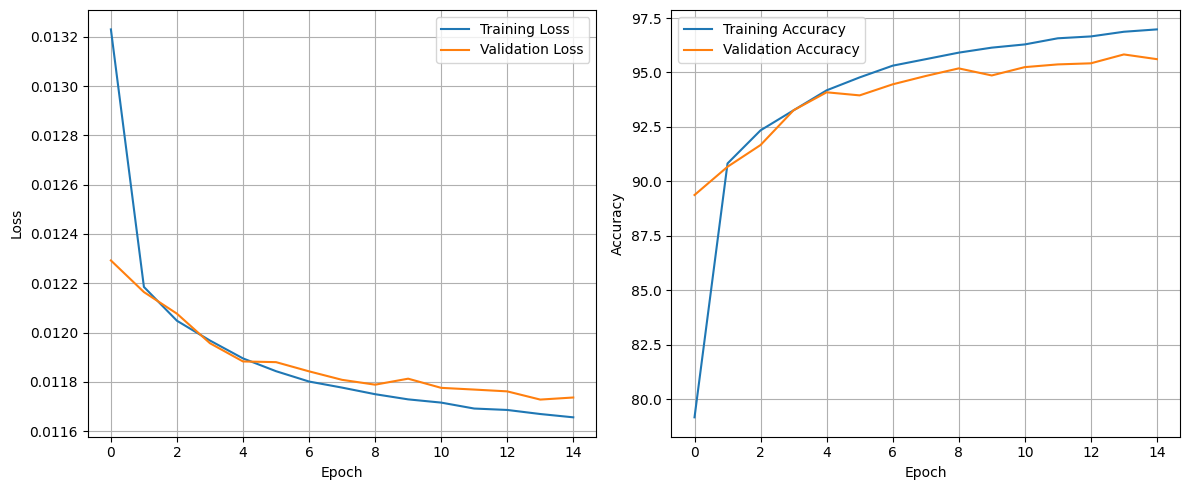

In [75]:
plt.figure(figsize=(12, 5))

ax= plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label="Training Loss")
plt.plot(valid_loss_hist, label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

ax = plt.subplot(1,2, 2)
plt.plot(train_acc_hist, label="Training Accuracy")
plt.plot(valid_acc_hist, label="Validation Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()

plt.tight_layout()
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [76]:
model.eval()
test_correct = 0
for inputs, labels in test_dataLoader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    _, predictions = torch.max(outputs.data, 1)
    test_correct += (predictions == labels).sum().item()

print(f'Test Accuracy: {test_correct/len(test_dataLoader)/batch_size*100:.2f}%')
    

Test Accuracy: 95.73%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [88]:
# Improving Hyperparameters
optimizer = optim.Adam(model.parameters(), lr = 0.0005, weight_decay=1e-5)  # L2 regularization (weight decay)
# Choosing model loss function
criterion = nn.CrossEntropyLoss()

In [89]:
# Training model again
Training()

Epoch 1 - Training Accuracy: 93.28% ; Training Loss: 1.54614
Epoch 1 - Validation Accuracy: 93.66% ; Validation Loss: 0.02396
Epoch 2 - Training Accuracy: 94.69% ; Training Loss: 1.52199
Epoch 2 - Validation Accuracy: 94.46% ; Validation Loss: 0.02375
Epoch 3 - Training Accuracy: 95.51% ; Training Loss: 1.51164
Epoch 3 - Validation Accuracy: 95.05% ; Validation Loss: 0.02363
Epoch 4 - Training Accuracy: 96.03% ; Training Loss: 1.50538
Epoch 4 - Validation Accuracy: 95.42% ; Validation Loss: 0.02356
Epoch 5 - Training Accuracy: 96.35% ; Training Loss: 1.50116
Epoch 5 - Validation Accuracy: 95.14% ; Validation Loss: 0.02358
Epoch 6 - Training Accuracy: 96.64% ; Training Loss: 1.49783
Epoch 6 - Validation Accuracy: 95.96% ; Validation Loss: 0.02347
Epoch 7 - Training Accuracy: 96.89% ; Training Loss: 1.49505
Epoch 7 - Validation Accuracy: 95.73% ; Validation Loss: 0.02348
Epoch 8 - Training Accuracy: 97.01% ; Training Loss: 1.49328
Epoch 8 - Validation Accuracy: 95.74% ; Validation Loss: 

In [90]:
# Testing the Model
model.eval()
test_correct = 0
for inputs, labels in test_dataLoader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    _, predictions = torch.max(outputs.data, 1)
    test_correct += (predictions == labels).sum().item()

print(f'Test Accuracy: {test_correct/len(test_dataLoader)/batch_size*100:.2f}%')
    

Test Accuracy: 96.04%


## Saving your model
Using `torch.save`, save your model for future loading.

In [93]:
save_path = "root/NNModel" + ".pth"
torch.save(model.state_dict(), save_path)
save_path_optim = "root/NNModel_optimizer" + ".pth"
torch.save(optimizer.state_dict(), save_path_optim )